# Data-Driven Discovery of Vehicle Dynamics Using Probabilistic Bayesian Neural Networks
## 1D PBNN for Straight Maneuver
### Team: [Chinmay Samak](mailto:csamak@clemson.edu), [Tanmay Samak](mailto:tsamak@clemson.edu)

Import Libraries

In [1]:
import ntpath
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp
tfd = tfp.distributions

GPU Acceleration

In [2]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


Import Data

In [3]:
# Define data directory
data_directory = 'AutoDRIVE-Nigel-Dataset/straight_30_hz'

In [4]:
def shorten_path(path):
    '''
    Function to view shortened paths.
    '''
    head,tail = ntpath.split(path)
    return tail

In [5]:
# Read the driving log
headers = ['timestamp','throttle','steering','leftTicks','rightTicks','posX','posY','posZ','roll','pitch','yaw','speed','angX','angY','angZ','accX','accY','accZ','cam0','cam1','lidar']

# Read each CSV file in dir "path/to/root_dir"
vehicle_logs = []
for file in Path(data_directory).glob("**/V1 Log.csv"):
    vehicle_logs.append(pd.read_csv(file, names=headers))

# Put the dataframes to a single dataframe
vehicle_log = pd.concat(vehicle_logs)

# Convert timestamp from string to datetime format
vehicle_log['timestamp'] = pd.to_datetime(vehicle_log['timestamp'], format='%Y_%m_%d_%H_%M_%S_%f')

# Shorten camera frame paths
vehicle_log['cam0'] = vehicle_log['cam0'].apply(shorten_path)
vehicle_log['cam1'] = vehicle_log['cam1'].apply(shorten_path)

# View the first 5 entries in the dataframe
vehicle_log.head()

,timestamp,throttle,steering,leftTicks,rightTicks,posX,posY,posZ,roll,pitch,...,speed,angX,angY,angZ,accX,accY,accZ,cam0,cam1,lidar
0,2023-04-26 21:09:55.567,0.0,0,0,0,8.940697e-07,-1.435360e-09,0.032498,-2.392900e-07,-1.276300e-08,...,0.0,2.933082e-07,0.000009,2.670090e-10,-9.842642e-05,2.184563e-07,0.0,Camera0_Frame_2023_04_26_21_09_55_567.jpg,Camera1_Frame_2023_04_26_21_09_55_567.jpg,inf inf inf inf inf inf inf inf inf inf inf in...
1,2023-04-26 21:09:55.607,0.0,0,0,0,8.940697e-07,-1.278782e-09,0.032498,2.751419e-08,-1.283946e-08,...,0.0,-2.108585e-07,-0.000005,8.599332e-11,3.620926e-08,2.311502e-07,0.0,Camera0_Frame_2023_04_26_21_09_55_607.jpg,Camera1_Frame_2023_04_26_21_09_55_607.jpg,inf inf inf inf inf inf inf inf inf inf inf in...
2,2023-04-26 21:09:55.649,0.0,0,0,0,8.940697e-07,-1.281219e-09,0.032498,-1.500774e-08,-1.283458e-08,...,0.0,3.484426e-08,-0.000006,8.443595e-11,4.180833e-08,2.312346e-07,0.0,Camera0_Frame_2023_04_26_21_09_55_649.jpg,Camera1_Frame_2023_04_26_21_09_55_649.jpg,inf inf inf inf inf inf inf inf inf inf inf in...
3,2023-04-26 21:09:55.698,0.0,0,0,0,8.940697e-07,-1.317854e-09,0.032498,-4.085440e-08,-1.283459e-08,...,0.0,2.546526e-07,-0.000006,5.591394e-11,2.611955e-08,2.047944e-07,0.0,Camera0_Frame_2023_04_26_21_09_55_698.jpg,Camera1_Frame_2023_04_26_21_09_55_698.jpg,inf inf inf inf inf inf inf inf inf inf inf in...
4,2023-04-26 21:09:55.738,0.0,0,0,0,8.940697e-07,-1.321890e-09,0.032498,-2.668042e-08,-1.284029e-08,...,0.0,1.282504e-07,-0.000007,8.430723e-11,4.678213e-08,2.316831e-07,0.0,Camera0_Frame_2023_04_26_21_09_55_738.jpg,Camera1_Frame_2023_04_26_21_09_55_738.jpg,inf inf inf inf inf inf inf inf inf inf inf in...


Visualize Raw Data

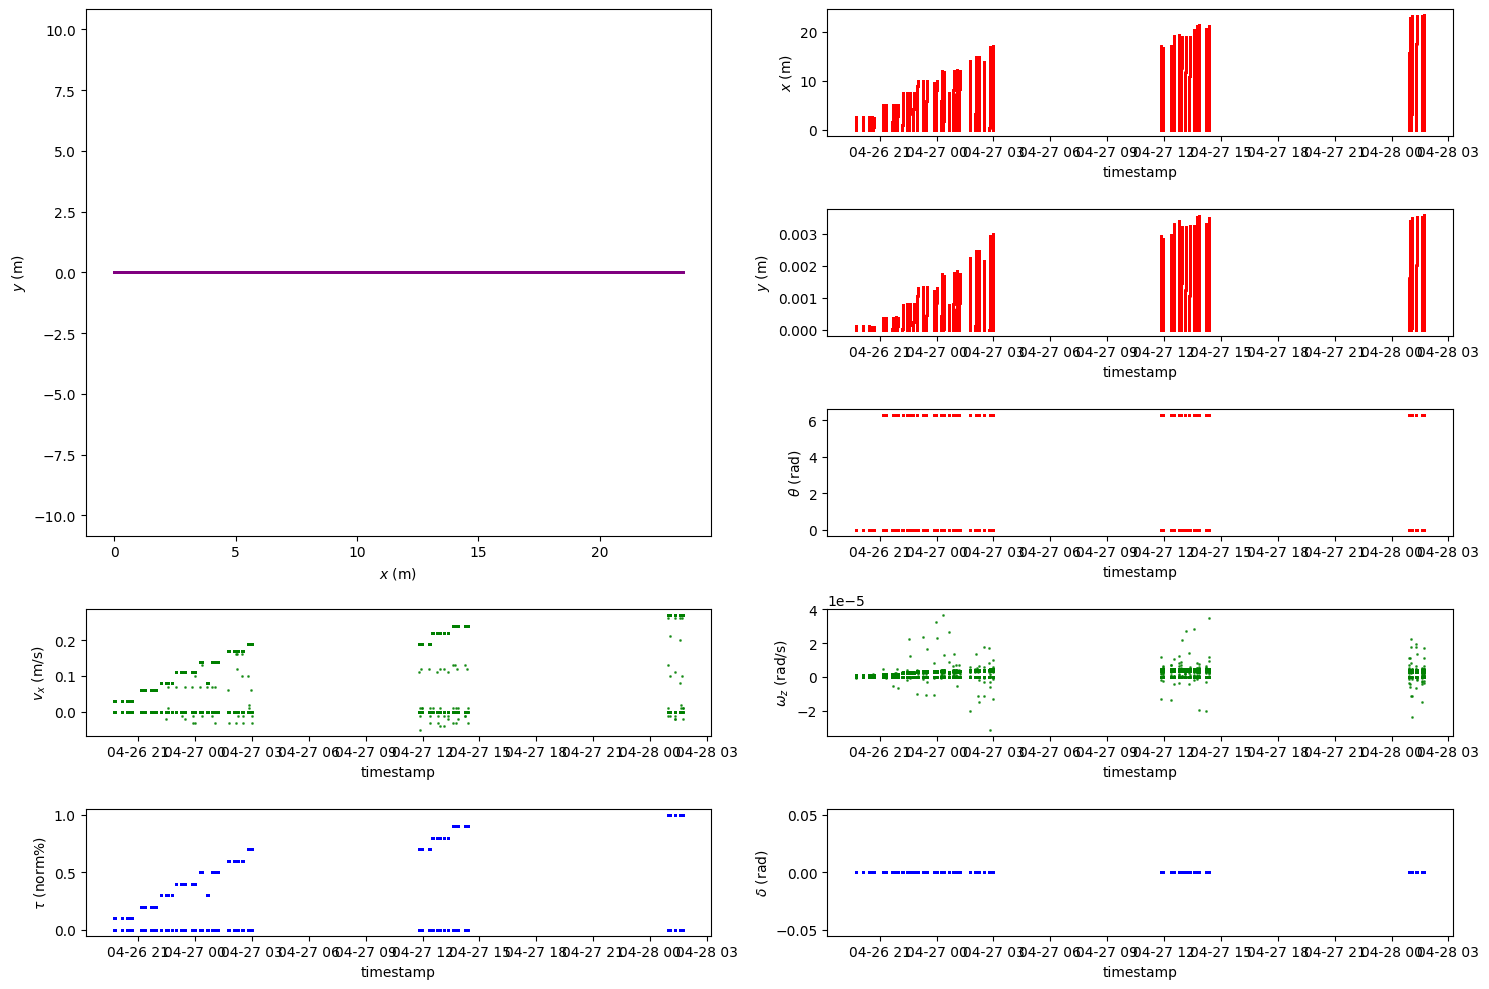

In [6]:
# Set figure size and sub-plot grid
fig = plt.figure(figsize=(15, 10))
G = gridspec.GridSpec(5, 2)

# Plot Y-position vs. X-position
axes_1 = plt.subplot(G[0:3, 0])
axes_1.scatter(np.asarray(vehicle_log['posX']), np.asarray(vehicle_log['posY']), s=1, color='purple', alpha=0.7)
axes_1.axis('equal')
axes_1.set_xlabel(r"$x$ (m)")
axes_1.set_ylabel(r"$y$ (m)")

# Plot X-position vs. elapsed time
axes_2 = plt.subplot(G[0, 1])
axes_2.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['posX']), s=1, color='red', alpha=0.7)
axes_2.set_xlabel(r"timestamp")
axes_2.set_ylabel(r"$x$ (m)")

# Plot Y-position vs. elapsed time
axes_3 = plt.subplot(G[1, 1])
axes_3.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['posY']), s=1, color='red', alpha=0.7)
axes_3.set_xlabel(r"timestamp")
axes_3.set_ylabel(r"$y$ (m)")

# Plot yaw vs. elapsed time
axes_4 = plt.subplot(G[2, 1])
axes_4.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['yaw']), s=1, color='red', alpha=0.7)
axes_4.set_xlabel(r"timestamp")
axes_4.set_ylabel(r"$\theta$ (rad)")

# Plot speed vs. elapsed time
axes_5 = plt.subplot(G[3, 0])
axes_5.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['speed']), s=1, color='green', alpha=0.7)
axes_5.set_xlabel(r"timestamp")
axes_5.set_ylabel(r"$v_x$ (m/s)")

# Plot yaw rate vs. elapsed time
axes_6 = plt.subplot(G[3, 1])
axes_6.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['angZ']), s=1, color='green', alpha=0.7)
axes_6.set_xlabel(r"timestamp")
axes_6.set_ylabel(r"$\omega_z$ (rad/s)")

# Plot throttle vs. elapsed time
axes_7 = plt.subplot(G[4, 0])
axes_7.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['throttle']), s=1, color='blue', alpha=0.7)
axes_7.set_xlabel(r"timestamp")
axes_7.set_ylabel(r"$\tau$ (norm%)")

# Plot steering angle vs. elapsed time
axes_8 = plt.subplot(G[4, 1])
axes_8.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['steering']), s=1, color='blue', alpha=0.7)
axes_8.set_xlabel(r"timestamp")
axes_8.set_ylabel(r"$\delta$ (rad)")

# Show the plot
plt.tight_layout()
plt.show()

Load Dataset

In [7]:
def load_dataset():
  '''
    Function to load dataset.
  '''
  x = vehicle_log['throttle']
  y = vehicle_log['speed']
  x.to_numpy()
  y.to_numpy()
  x1 = x[:-1].copy() # Drop last state from features
  x2 = y[:-1].copy() # Drop last control input from features
  y = y[1:].copy() # Drop first state from labels
  x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(x1, x2, y, test_size=0.2, random_state=42, shuffle=True)
  return x1_train.to_numpy(), x2_train.to_numpy(), y_train.to_numpy(), x1_test.to_numpy(), x2_test.to_numpy(), y_test.to_numpy()

x1_train, x2_train, y_train, x1_test, x2_test, y_test = load_dataset()

Visualize Dataset

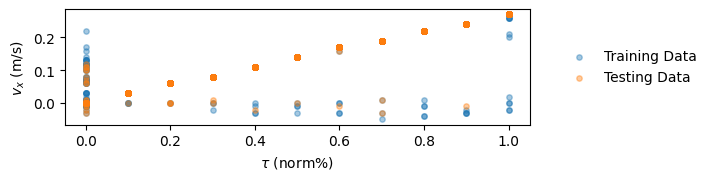

In [8]:
# Set figure size
plt.figure(figsize=(6, 1.5))
# Plot training data
plt.scatter(x1_train, y_train, s=15, label="Training Data", alpha=0.4)
plt.scatter(x1_test, y_test, s=15, label="Testing Data", alpha=0.4)
# Add labels and legend and show the plot
plt.xlabel(r"$\tau$ (norm%)")
plt.ylabel(r"$v_x$ (m/s)")
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.show()

Define and Visualize PBNN Model

In [9]:
# Define the prior weight distribution -- non-trainable standard multivariate Gaussian, i.e. N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfp.layers.DistributionLambda(lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
    ])
    return prior_model

# Define the variational posterior weight distribution -- trainable multivariate Gaussian, i.e. N(mu, sigma)
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfp.layers.MultivariateNormalTriL(n)
    ])
    return posterior_model

# Define the negative log likelihood loss function
def nll_loss(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [10]:
# Create hybrid probabilistic Bayesian neural network model
model = Sequential([
    tfp.layers.DenseVariational(input_shape=(2, ),
                                units=8,
                                make_prior_fn=prior,
                                make_posterior_fn=posterior,
                                kl_weight=1/x1_train.shape[0],
                                activation='sigmoid'
                                ),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    tfp.layers.DenseVariational(units=tfp.layers.IndependentNormal.params_size(1),
                                make_prior_fn=prior,
                                make_posterior_fn=posterior,
                                kl_weight=1/len(x1_train),
                                kl_use_exact=True
                                ),
    tfp.layers.IndependentNormal(1)
])

model.compile(loss='mse', optimizer=RMSprop(learning_rate=0.001))
model.summary()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVar  (None, 8)                324       
 iational)                                                       
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_variational_1 (DenseV  (None, 2)                189       
 ariational)                                                    

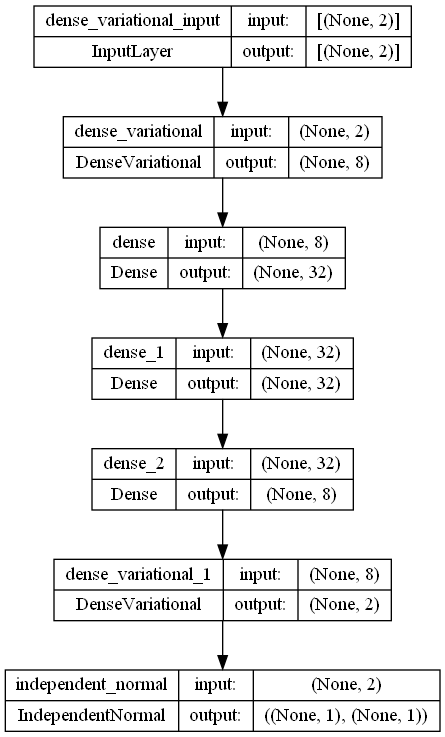

In [11]:
# Plot the model
plot_model(model, to_file='PBNN.png', show_shapes=True, show_layer_names=True)

Train PBNN Model

In [12]:
def fit_model(iter, model, xs1, xs2, ys, x1_test, x2_test, y_test, epochs=10, as_batch=100, verbose=False):

    xs = np.stack([xs1, xs2], axis=1)
    x_test = np.stack([x1_test, x2_test], axis=1)

    # Fit model
    history = model.fit(xs, ys, validation_data=(x_test, y_test), epochs=epochs, verbose=verbose);

    # Visualize training performance

    # Get training and testing losses for all the epochs from `history`
    if verbose:
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(loss))

        # Plot the training and testing loses
        plt.figure()
        plt.plot(np.asarray(epochs)+1, loss, 'r', label='Training Loss')
        plt.plot(np.asarray(epochs)+1, val_loss, 'b', label='Testing Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    # Visualize model predictions with uncertainty

    # Get pridictions
    x_train = np.stack([x1_train, x2_train], axis=1)
    yhats = [model(x_train) for _ in range(100)];
    avgm = np.zeros_like(x1_train);
    avgs = np.zeros_like(x1_train);
    means = [];

    plt.figure(figsize=[6, 1.5]); # inches
    plt.clf();
    plt.scatter(x1_train, y_train, s=15, label="Entire Dataset", alpha=0.4);
    plt.scatter(xs1, ys, s=15, label="Data Samples", alpha=0.6);
    plt.scatter(x1_train, yhats[0].sample(), s=15,  color='orange', label="Model Predictions", alpha=0.4);

    # Epistemic uncertainty
    for i, yhat in enumerate(yhats):
        m = np.squeeze(yhat.mean());
        s = np.squeeze(yhat.stddev());
        plt.plot(x1_train, m, color='red', label='Ensemble $\mu_i$' if i == 0 else None, linewidth=0.5, alpha=0.2);
        avgm += m;
        avgs += s;
        means.append(m);
    plt.plot(x1_train, avgm/len(yhats), color='black', label='Overall $\mu$', linewidth=4, alpha=0.5);

    # Aleotoric uncertainty
    x1_sim = np.asarray([])
    x2_sim = np.asarray([])
    x_sim = np.asarray([])
    for i in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]: # simulated data for plotting
        sim_idx = np.where(x1_train == i)[0][0];
        x_1 = x1_train[sim_idx];
        x_2 = x2_train[sim_idx];
        x1_sim = np.append(x1_sim, x_1);
        x2_sim = np.append(x2_sim, x_2);
    x_sim = np.stack([x1_sim, x2_sim], axis=1);
    yhat = model(x_sim);
    mu = np.squeeze(yhat.mean());
    sigma = np.squeeze(yhat.stddev());
    plt.fill_between(x1_sim, mu-2*sigma, mu+2*sigma, color='lawngreen', label='$\mu\pm2\sigma$', alpha=0.3);

    # plt.ylim(-0.,0.4);
    # plt.yticks(np.linspace(0, 15, 4)[1:]);
    # plt.xticks(np.linspace(*x_range, num=9));

    if iter !=0:
        plt.scatter(xs1[-as_batch:], ys[-as_batch:], s=30, marker='*', color='m', label="New Sample Batch", alpha=1.0);

    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom');
    ax.yaxis.set_ticks_position('left');
    ax.spines['left'].set_position(('data', 0));
    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));
    plt.title("Iteration {}".format(iter+1))

    return means;

Active Learning

In [13]:
# Initial samples
ns = 4000
as_batch = 40
rnd_idx = np.random.choice(len(x1_train), ns, replace=False)
xs1_train = x1_train[rnd_idx]
xs2_train = x2_train[rnd_idx]
ys_train = y_train[rnd_idx]

C:\Users\tsamak\AppData\Local\Temp\ipykernel_44052\2249237204.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[6, 1.5]); # inches


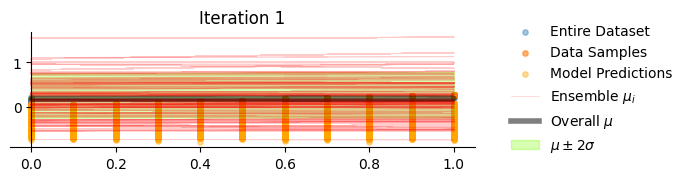

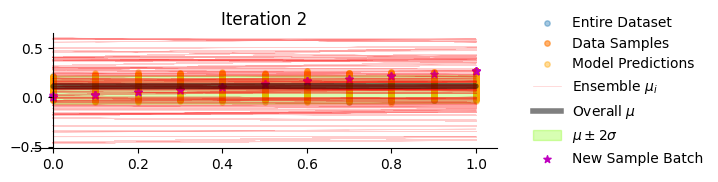

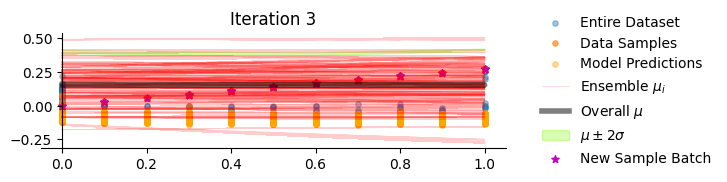

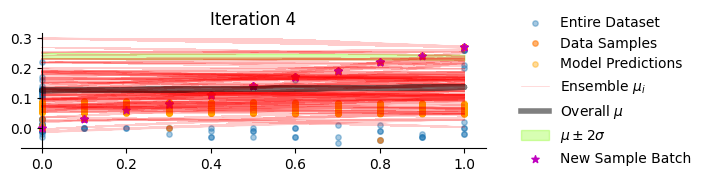

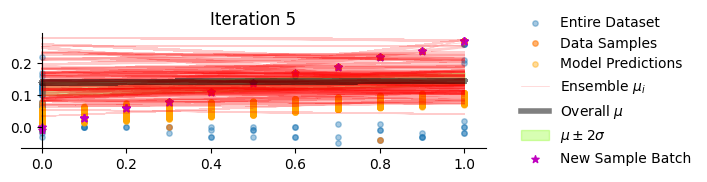

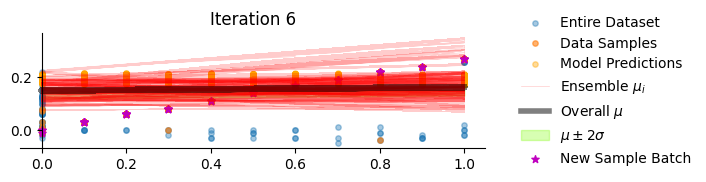

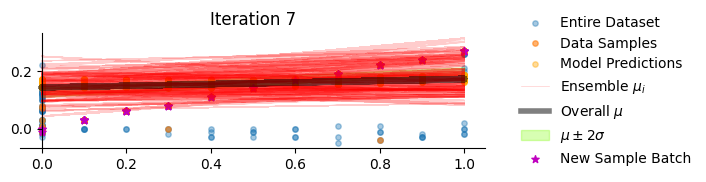

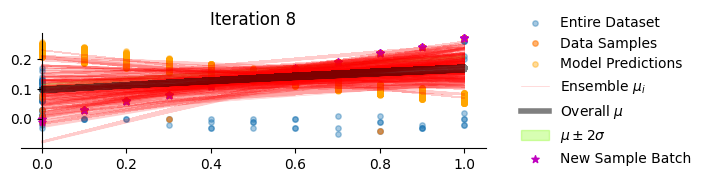

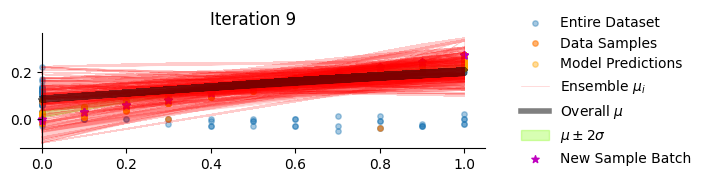

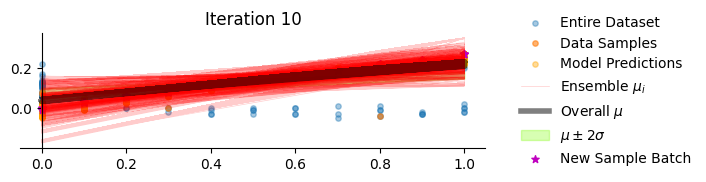

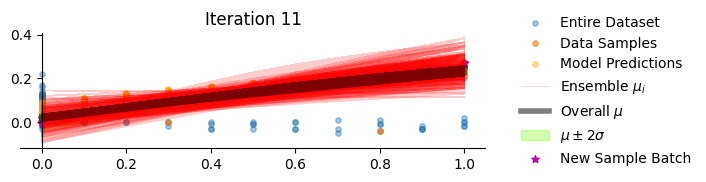

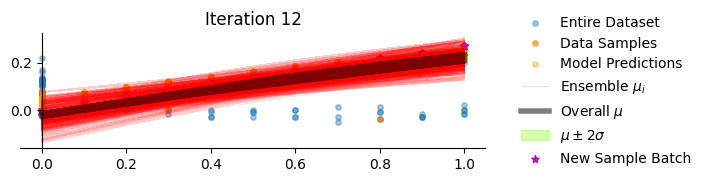

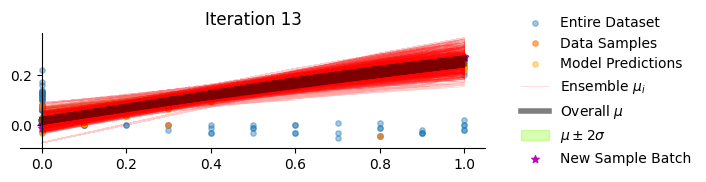

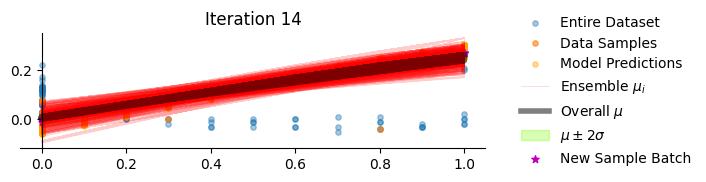

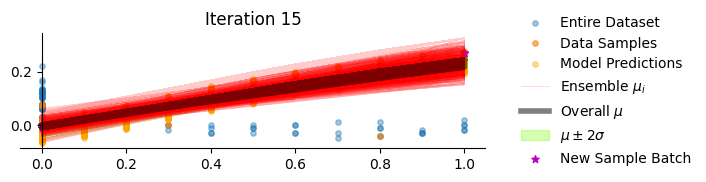

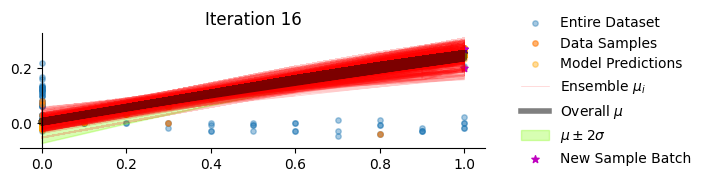

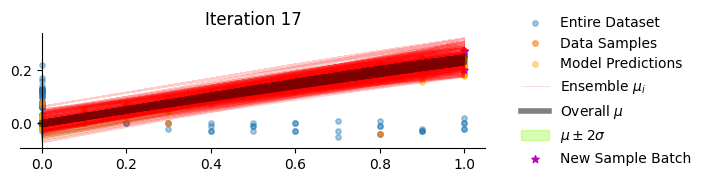

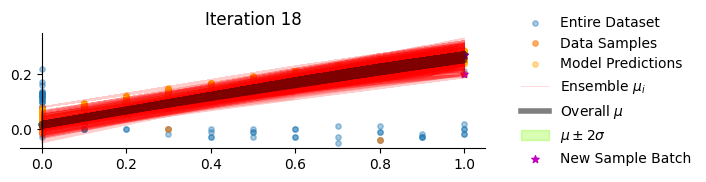

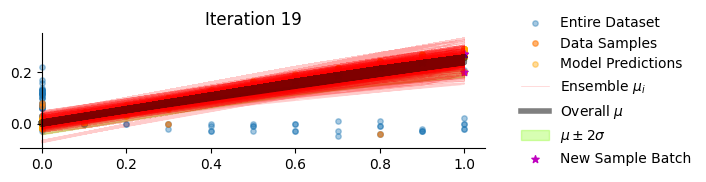

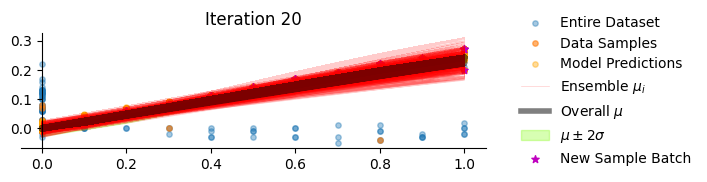

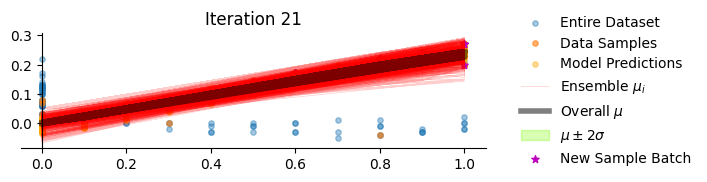

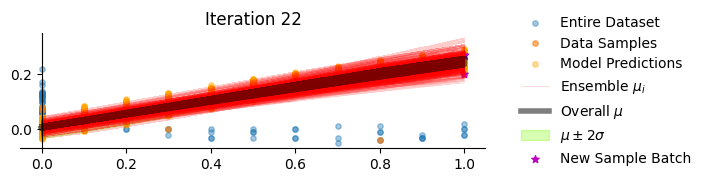

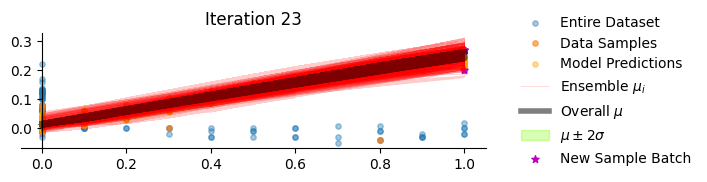

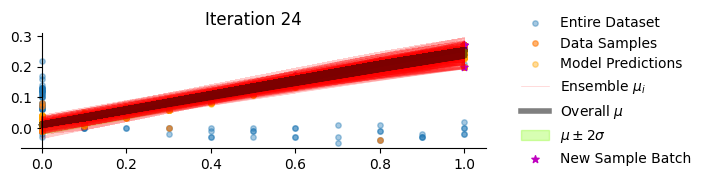

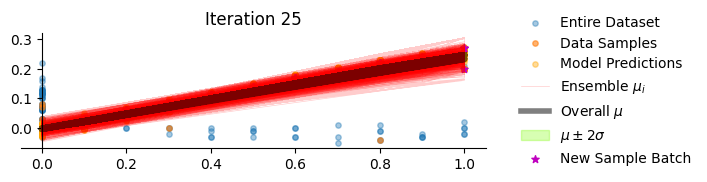

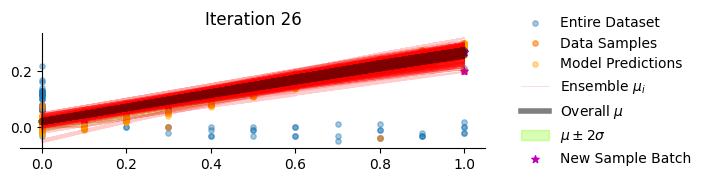

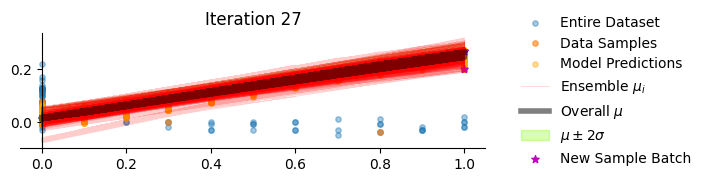

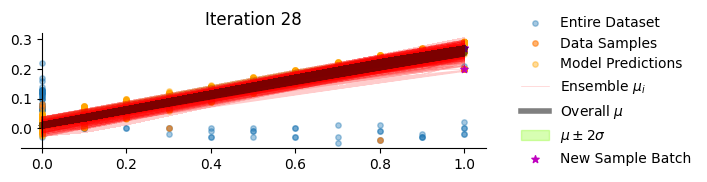

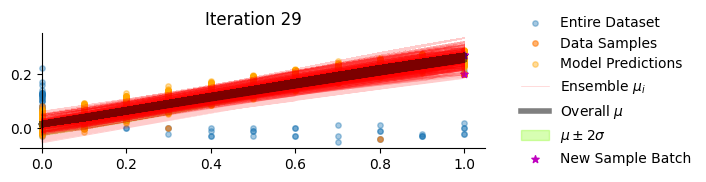

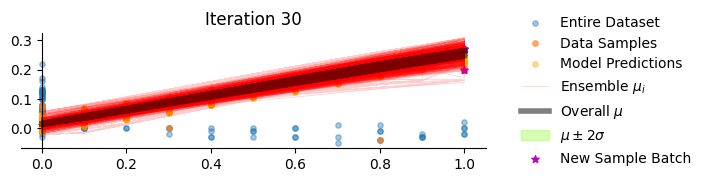

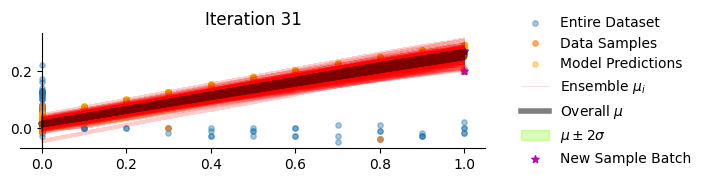

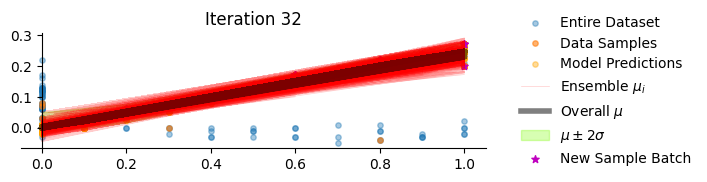

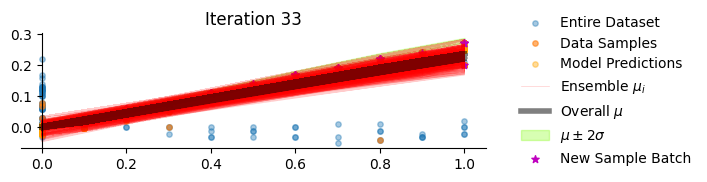

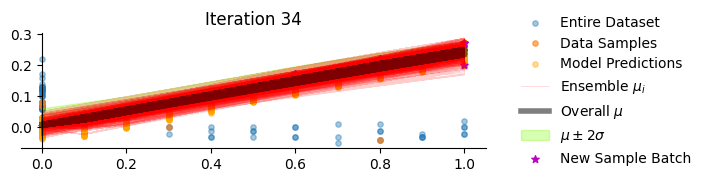

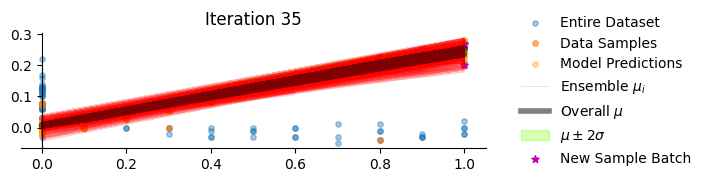

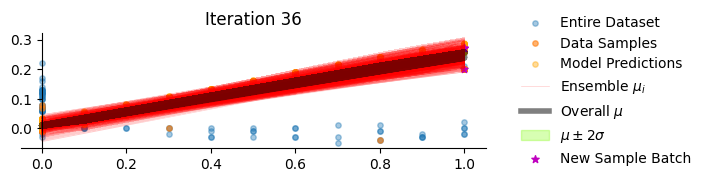

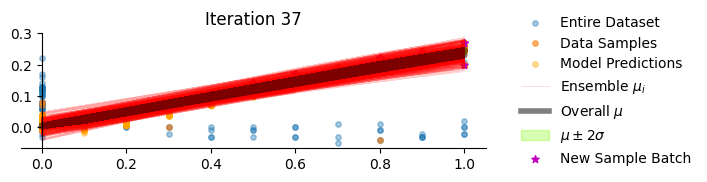

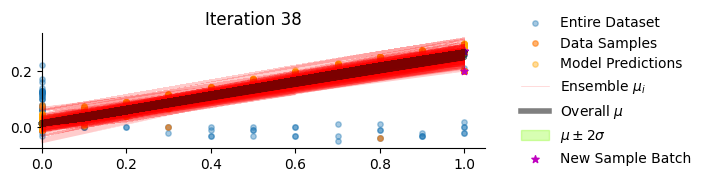

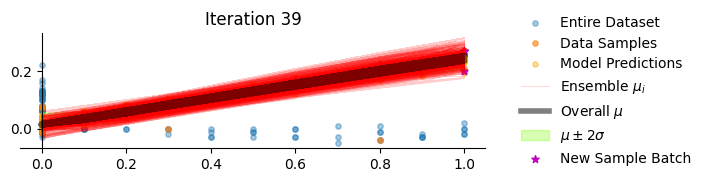

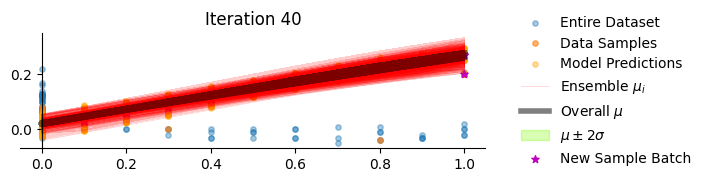

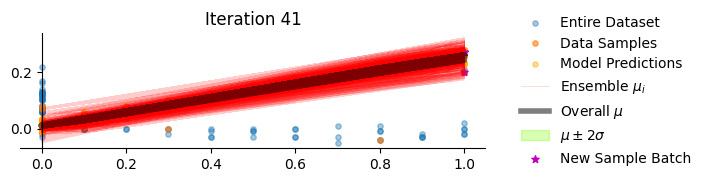

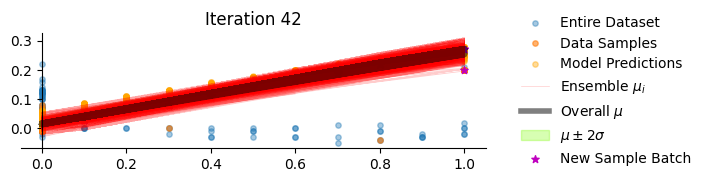

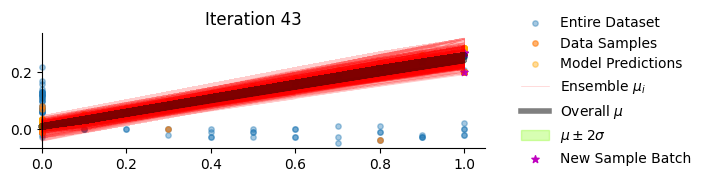

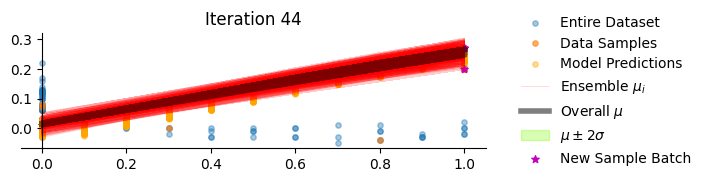

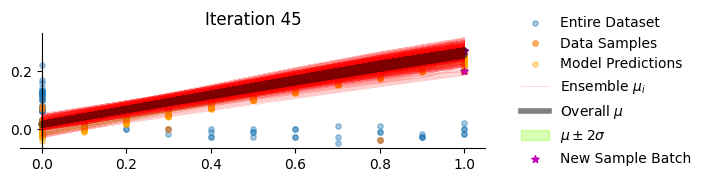

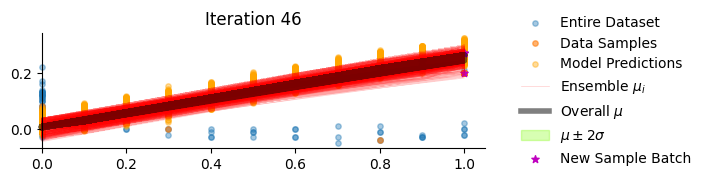

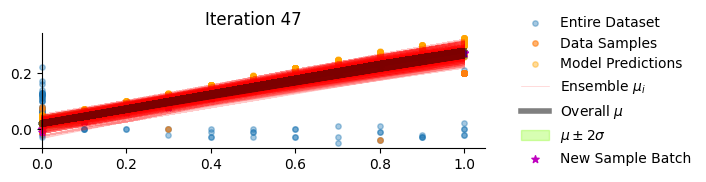

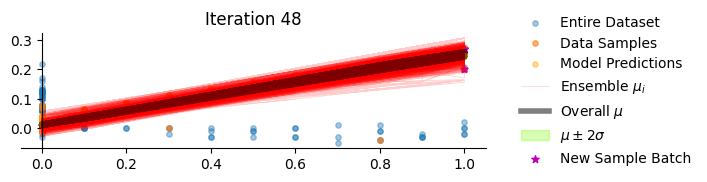

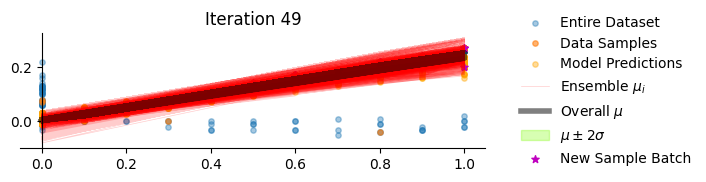

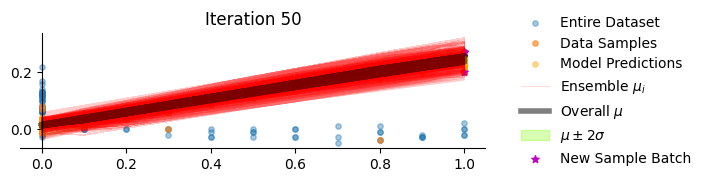

In [14]:
for i in range(50):
    means = fit_model(i, model, xs1_train, xs2_train, ys_train, x1_test, x2_test, y_test, epochs=10, as_batch=as_batch, verbose=False); # Train BNN model and visualize predictions
    a = np.std(np.asarray(means), axis=0); # Acquisition function (max epistemic uncertainty)
    next_i = np.where(a == max(a))[0][0]; # Sample index based on acquisition function
    xs1_train = np.append(xs1_train, x1_train[int(next_i-(as_batch/2)):int(next_i+(as_batch/2))]); # Add new data points around the next sample to XS and reshape the resulting flattened array
    xs2_train = np.append(xs2_train, x2_train[int(next_i-(as_batch/2)):int(next_i+(as_batch/2))]); # Add new data points around the next sample to XS and reshape the resulting flattened array
    ys_train = np.append(ys_train, y_train[int(next_i-(as_batch/2)):int(next_i+(as_batch/2))]); # Add new data points around the next sample to YS
    # print("New Sample Batch X: {}".format(xs1_train[-as_batch:]))
    # print("New Sample Batch X: {}".format(xs2_train[-as_batch:]))
    # print("New Sample Batch Y: {}".format(ys_train[-as_batch:]))

Visualize Predictions

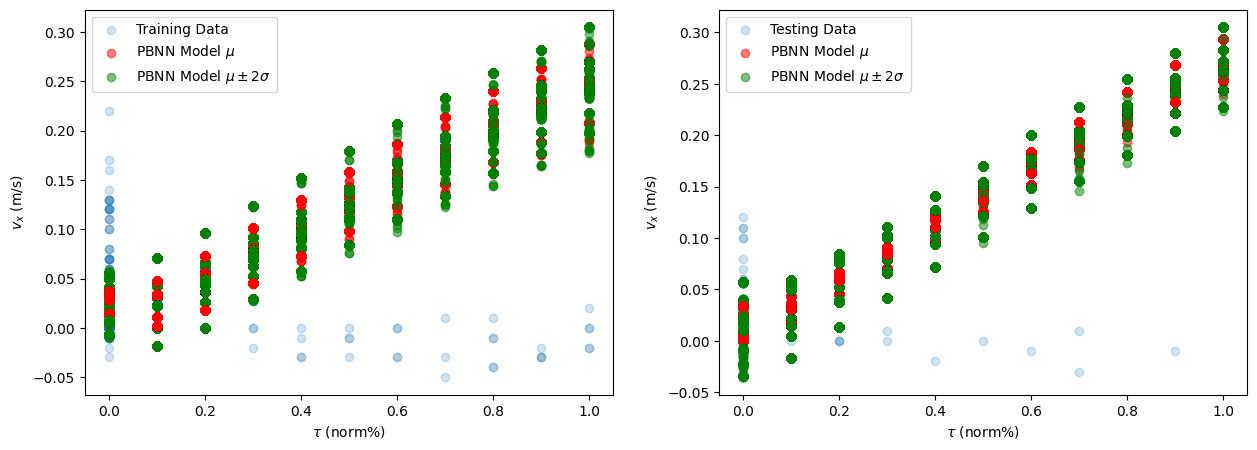

In [15]:
# Plot an ensemble of trained probabilistic regressions
figure, axes = plt.subplots(1, 2, figsize = (15, 5))

# Training data
axes[0].scatter(x1_train, y_train, alpha=0.2, label='Training Data')
x_train = np.stack([x1_train, x2_train], axis=1)
x_test = np.stack([x1_test, x2_test], axis=1)
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2std = y_hat - 2 * y_model.stddev()
    y_hat_p2std = y_hat + 2 * y_model.stddev()
    if _ == 0:
        axes[0].scatter(x1_train, y_hat, color='red', alpha=0.5, label='PBNN Model $\mu$')
        axes[0].scatter(x1_train, y_hat_m2std, color='green', alpha=0.5, label='PBNN Model $\mu \pm 2 \sigma$')
        axes[0].scatter(x1_train, y_hat_p2std, color='green', alpha=0.5)
    else:
        axes[0].scatter(x1_train, y_hat, color='red', alpha=0.5)
        axes[0].scatter(x1_train, y_hat_m2std, color='green', alpha=0.5)
        axes[0].scatter(x1_train, y_hat_p2std, color='green', alpha=0.5)
axes[0].set_xlabel(r"$\tau$ (norm%)")
axes[0].set_ylabel(r"$v_x$ (m/s)")
axes[0].legend(loc='best')

# Testing data
axes[1].scatter(x1_test, y_test, alpha=0.2, label='Testing Data')
for _ in range(5):
    y_model = model(x_test)
    y_hat = y_model.mean()
    y_hat_m2std = y_hat - 2 * y_model.stddev()
    y_hat_p2std = y_hat + 2 * y_model.stddev()
    if _ == 0:
        axes[1].scatter(x1_test, y_hat, color='red', alpha=0.5, label='PBNN Model $\mu$')
        axes[1].scatter(x1_test, y_hat_m2std, color='green', alpha=0.5, label='PBNN Model $\mu \pm 2 \sigma$')
        axes[1].scatter(x1_test, y_hat_p2std, color='green', alpha=0.5)
    else:
        axes[1].scatter(x1_test, y_hat, color='red', alpha=0.5)
        axes[1].scatter(x1_test, y_hat_m2std, color='green', alpha=0.5)
        axes[1].scatter(x1_test, y_hat_p2std, color='green', alpha=0.5)
axes[1].set_xlabel(r"$\tau$ (norm%)")
axes[1].set_ylabel(r"$v_x$ (m/s)")
axes[1].legend(loc='best')

# Show plot
plt.show()